<a href="https://colab.research.google.com/github/ayusufsirin/stereo_vision_starter/blob/main/kitti_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preperation

## Install Requirements

Set the Colab runtime type to "T4 GPU"

In [1]:
# !nvcc --version


In [2]:
# !nvidia-smi


In [3]:
# !pip install cupy-cuda12x


In [4]:
# !pip install GitPython open3d


In [5]:
# !pip install opencv-contrib-python


## Read the Files

In [36]:
import os
from glob import glob
import cv2
import open3d as o3d
import numpy as np
import cupy as cp
import cupyx as cpx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)


def plotScaledNp(npArrs, **kwargs):
    N = len(npArrs)
    
    for i in range(N):
        plt.subplot(N, 1, i + 1)
        plt.imshow(npArrs[i][1], **kwargs)
        plt.title(npArrs[i][0])
        
    plt.rcParams["figure.figsize"] = (50, 20)
    plt.tight_layout()
    plt.show()


In [3]:
# Clone the git repo
from git import Repo
import os

repo_url = 'https://github.com/ayusufsirin/stereo_vision_starter'
local_dir = 'stereo_vision_starter'

# Check if the directory exists and is a Git repository
if os.path.isdir(local_dir) and os.path.isdir(os.path.join(local_dir, '.git')):
    try:
        repo = Repo(local_dir)
        # Ensure the local repository is linked to the specified URL
        if repo.remotes.origin.url == repo_url:
            print("Repository already exists, pulling latest changes...")
            repo.remotes.origin.pull()
        else:
            print("Directory exists but is not linked to the specified repository URL.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    try:
        print("Cloning repository...")
        Repo.clone_from(repo_url, local_dir)
        print("Repository cloned successfully.")
    except Exception as e:
        print(f"An error occurred while cloning the repository: {e}")


Repository already exists, pulling latest changes...
An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git pull -v -- origin
  stderr: 'fatal: detected dubious ownership in repository at '/media/joseph/Development/SFITC/stereo_vision_starter/stereo_vision_starter''


### Read GT, Lidar, and Stereo

In [4]:
DATA_PATH = r'stereo_vision_starter/dataset/data_scene_flow/training/'
RAW_DATA_PATH = r'stereo_vision_starter/dataset/2011_09_26/2011_09_26_drive_0057_sync'

left_image_paths = sorted(
    glob(os.path.join(RAW_DATA_PATH, 'image_02/data/0000000125.png')))
right_image_paths = sorted(
    glob(os.path.join(RAW_DATA_PATH, 'image_03/data/0000000125.png')))

# get LiDAR data
gt_paths = sorted(glob(os.path.join(DATA_PATH, 'disp_noc_0/000112_10.png')))

lidar_paths = sorted(
    glob(os.path.join(RAW_DATA_PATH, 'velodyne_points/data/0000000125.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(lidar_paths)}")
print(f"Number of GT point clouds: {len(gt_paths)}")


Number of left images: 1
Number of right images: 1
Number of LiDAR point clouds: 1
Number of GT point clouds: 1


### Read Calibrations Data

In [5]:
calib_paths = sorted(glob(
    'stereo_vision_starter/dataset/data_scene_flow_calib/training/calib_cam_to_cam/000112.txt'))

with open(calib_paths[0], 'r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x)
                  for x in calib[25].strip().split(' ')[1:]]).reshape((3, 4))
P_right = np.array([float(x)
                   for x in calib[33].strip().split(' ')[1:]]).reshape((3, 4))

# get rectified rotation matrices
R_left_rect = np.array(
    [float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array(
    [float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0, 0, 0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0, 0, 0, 1], axis=1)


In [6]:
def decompose_projection_matrix(P):
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T


In [7]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)


In [8]:
print(R_left)
print(R_left_rect)
print()
print(R_right)
print(R_right_rect)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 9.998817e-01  1.511453e-02 -2.841595e-03  0.000000e+00]
 [-1.511724e-02  9.998853e-01 -9.338510e-04  0.000000e+00]
 [ 2.827154e-03  9.766976e-04  9.999955e-01  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.9998321  -0.00719314  0.01685599]
 [ 0.0072328   0.9999712  -0.00229358]
 [-0.01683901  0.00241512  0.9998553 ]]


In [9]:
print(K_left.dtype)
print(T_left)
print(R_left)

print(K_right)
print(T_right)
print(R_right)

float64
[[-5.98492648e-02]
 [ 3.57927150e-04]
 [-2.74588400e-03]
 [ 1.00000000e+00]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]
[[ 0.47286266]
 [-0.00239497]
 [-0.00272991]
 [ 1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [10]:
calib_paths = sorted(glob(
    'stereo_vision_starter/dataset/data_scene_flow_calib/training/calib_velo_to_cam/*.txt'))

with open(calib_paths[0], 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x)
                      for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x)
                      for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((
    np.hstack((R_cam_velo, t_cam_velo)),
    np.array([0, 0, 0, 1])
))

print(R_cam_velo)
print(t_cam_velo)
print(T_cam_velo)

[[ 7.533745e-03 -9.999714e-01 -6.166020e-04]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01]
 [ 9.998621e-01  7.523790e-03  1.480755e-02]]
[[-0.00406977]
 [-0.07631618]
 [-0.2717806 ]]
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]


In [11]:
index = 0

left_image = cv2.cvtColor(cv2.imread(
    left_image_paths[index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(
    right_image_paths[index]), cv2.COLOR_BGR2RGB)

## Stereo Disparity

In [12]:
def compute_sgbm_disparity(left_image, right_image, num_disparities=5*16,
                           block_size=11, window_size=5, display=False):
    """ Computes the disparity of an image pair using the SGBM algoithm.
        Inputs:
            image_left/_right - (MxN) grayscale input images
            see opencv documentation for "StereoBM_create"
        Outputs:
            disparity (MxN) computed disparity map for the input images

        NOTE: image_left must be the left image (same for the right) or
              unexpected results will occur due to
    """
    # P1 and P2 control disparity smoothness (recommended values below)
    P1 = 8 * 3 * window_size**2
    P2 = 32 * 3 * window_size**2
    sgbm_obj = cv2.StereoSGBM_create(0, num_disparities, block_size,
                                     P1, P2, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)

    # compute disparity
    disparity = sgbm_obj.compute(
        left_image, right_image).astype(np.float32)/16.0

    # display is desired
    if display:
        plt.figure(figsize=(40, 20))
        plt.imshow(disparity, cmap='cividis')
        plt.title('Disparity Map', size=25)
        plt.show()

    return disparity


def calc_depth_map(disp_left, K_left, T_left, T_right):
    ''' Computes Depth map from Intrinsic Camera Matrix and Translations vectors.
        For KITTI, the depth is in meters.
        '''
    # Get the focal length from the K matrix
    f = K_left[0, 0]

    # Get the distance between the cameras from the t matrices (baseline)
    b = np.abs(T_left[0] - T_right[0])[0]

    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left <= 0] = 1e-5

    # Calculate the depths
    depth_map = f*b / disp_left

    return depth_map


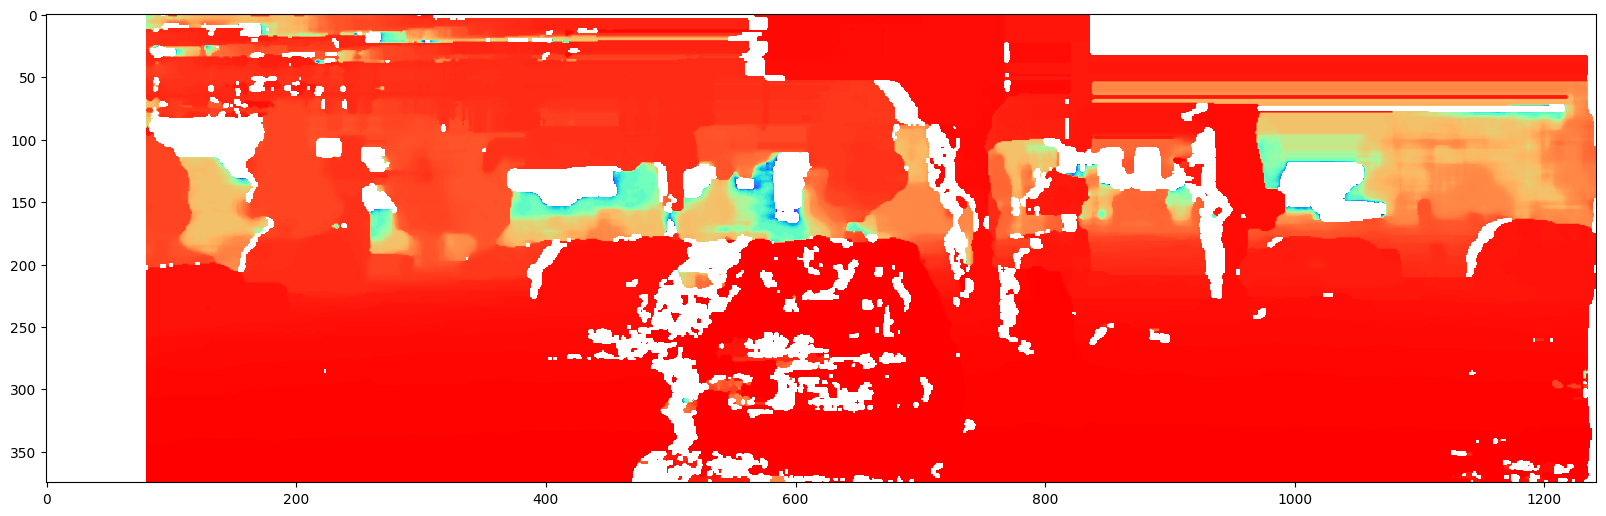

In [13]:
from IPython.display import Image
from ipywidgets import interact, interactive, fixed

left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)

disparity = interactive(compute_sgbm_disparity,
                        left_image=fixed(left_image_gray),
                        right_image=fixed(right_image_gray),
                        num_disparities=(0, 512, 16),
                        block_size=(1, 19, 2),
                        window_size=(1, 13, 2),
                        display=fixed(True))
# display(disparity)

num_disparities = disparity.kwargs['num_disparities']
block_size = disparity.kwargs['block_size']
window_size = disparity.kwargs['window_size']

disparity = compute_sgbm_disparity(left_image_gray,
                                   right_image_gray,
                                   num_disparities,
                                   block_size,
                                   window_size,
                                   display=False)

stereo_depth_map = calc_depth_map(disparity, K_left, T_left, T_right)
stereo_depth_map[stereo_depth_map > 38000000.0] = np.NAN

plt.imshow(stereo_depth_map, cmap='rainbow_r')  # or 'cividis_r' or 'cividis'


nan

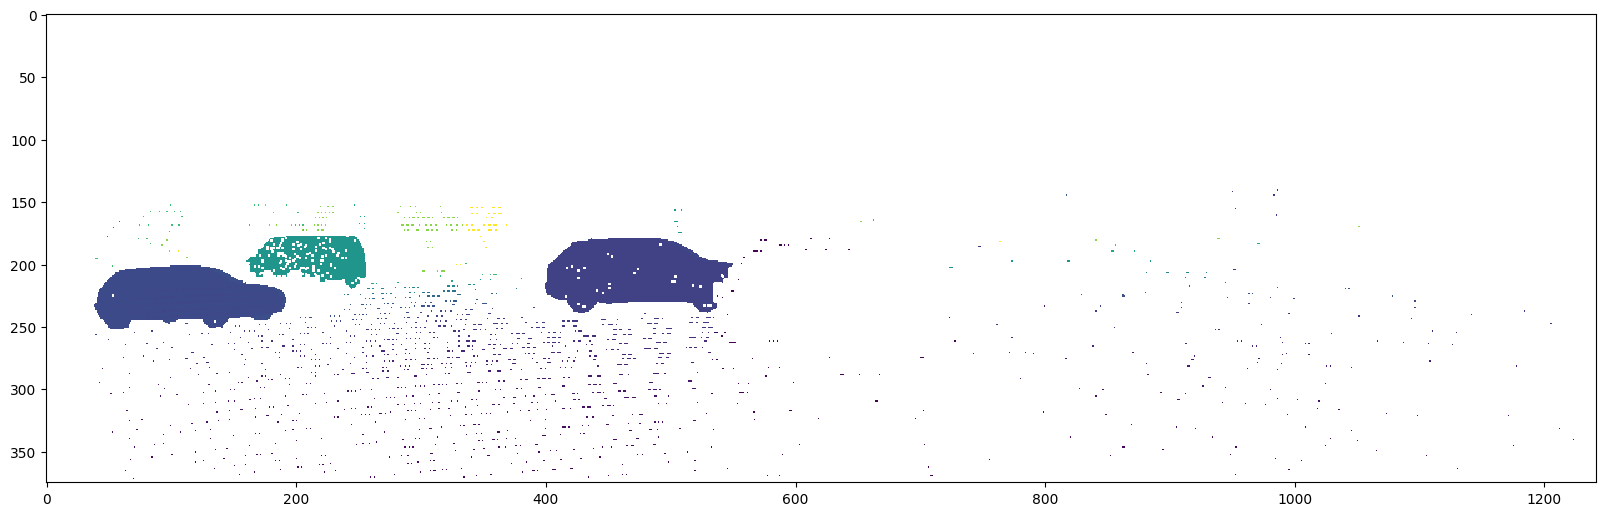

In [14]:
gt = gt_paths[index]

gt_disp = cv2.imread(gt, cv2.IMREAD_GRAYSCALE)
# print(gt, type(gt_depth_map))

gt_disp = gt_disp.astype(np.float32)
# gt_disp[gt_disp == 0] = 1e-05

gt_depth_map = calc_depth_map(gt_disp, K_left, T_left, T_right)
gt_depth_map[gt_depth_map > 38000000.0] = np.NAN
# gt_depth_map[gt_depth_map == 0] = np.NAN
# gt_depth_map[gt_depth_map == np.Infinity] = np.NAN

plt.imshow(gt_depth_map)
gt_depth_map[50, 600]


## Lidar Projection

In [15]:
def get_velo2cam(lidar_bin, P=P_left, R=R_left_rect, T=T_cam_velo):
    ''' Converts the LiDAR point cloud to camera (u, v, z) image coordinates,
        where z is in meters
        '''
    # read in LiDAR data
    scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1, 4))

    # convert to homogeneous coordinate system
    velo_points = scan_data[:, 0:3]  # (x, y, z) --> (front, left, up)
    
    print(velo_points.shape)
    
    # velo_points[2] = velo_points[2] / 10
    
    # homogeneous LiDAR points
    velo_points = np.insert(velo_points, 3, 1, axis=1).T

    # delete negative liDAR points
    velo_points = np.delete(velo_points, np.where(
        velo_points[3, :] < 0), axis=1)

    # possibly use RANSAC to remove the ground plane for better viewing?

    # convert to camera coordinates
    print(velo_points.shape)
    
    velo_camera = P @ R @ T @ velo_points
    
    print('velo_camera', velo_camera.shape)

    # delete negative camera points ??
    velo_camera = np.delete(velo_camera, np.where(
        velo_camera[2, :] < 0)[0], axis=1)

    # get camera coordinates u,v,z
    velo_camera[:2] /= velo_camera[2, :]

    return velo_camera


def project_velo2cam(lidar_bin, image):
    ''' Projects LiDAR point cloud onto the image coordinate frame '''

    # get camera (u, v, z) coordinates
    velo_camera = get_velo2cam(lidar_bin)

    (u, v, z) = velo_camera

    # remove outliers (points outside of the image frame)
    img_h, img_w, _ = image.shape
    u_out = np.logical_or(u < 0, u > img_w)
    v_out = np.logical_or(v < 0, v > img_h)
    outlier = np.logical_or(u_out, v_out)
    velo_camera = np.delete(velo_camera, np.where(outlier), axis=1)

    return velo_camera


def uvz_to_depth_map(uvz, image_shape):
    depth_map = np.zeros(image_shape, dtype=np.float32)

    u, v, z = uvz
    u, v = u.astype(np.int32), v.astype(np.int32)

    valid_indices = (u >= 0) & (u < image_shape[1]) & (
        v >= 0) & (v < image_shape[0])
    u, v, z = u[valid_indices], v[valid_indices], z[valid_indices]

    depth_map[v, u] = z

    return depth_map


(117388, 3)
(4, 117388)
velo_camera (3, 117388)
16697


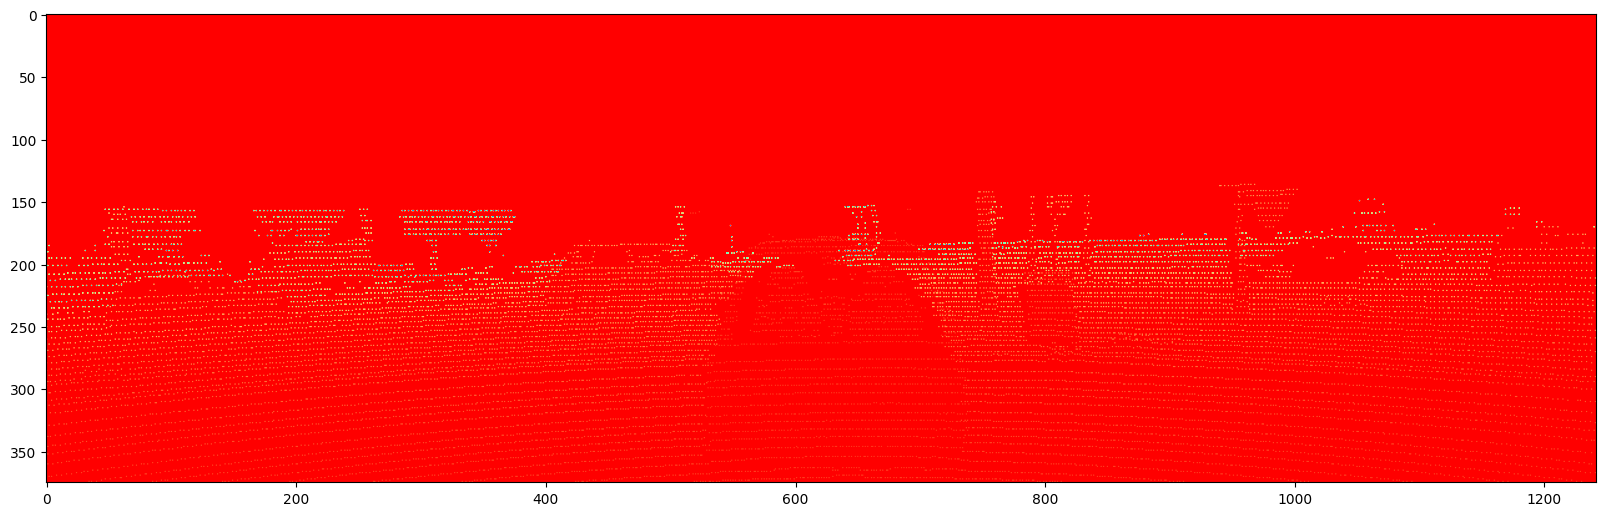

In [16]:
lidar_bin = lidar_paths[index]
(u, v, z) = project_velo2cam(lidar_bin, left_image)
lidar_depth_map = uvz_to_depth_map((u, v, z), left_image.shape[:2])

print(np.count_nonzero(lidar_depth_map))

# lidar_depth_map[lidar_depth_map != 0] = np.inf
# lidar_depth_map[lidar_depth_map == 0] = stereo_depth_map[lidar_depth_map == 0]
# lidar_depth_map[lidar_depth_map == 0] = np.nan

plt.imshow(lidar_depth_map, cmap='rainbow_r')


## Lidar Sperical Plane

(117388, 3)
(4, 117388)
velo_camera (3, 117388)
(-90.0, 0.0, 0.0)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


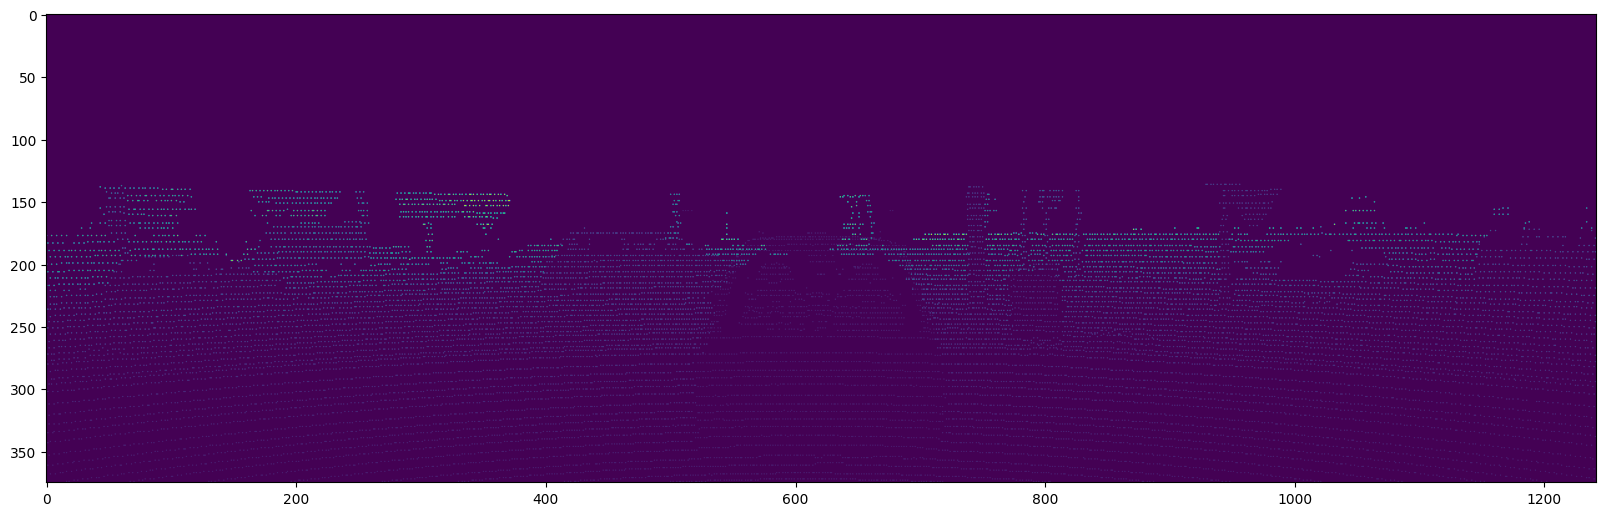

In [17]:
# scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1, 4))

# velo_points = scan_data[:, 0:3]  # (x, y, z) --> (front, left, up)

# # Convert to cylindrical coordinates
# theta = np.arctan2(velo_points[:, 1], velo_points[:, 0])  # Angle around z-axis
# h = velo_points[:, 2]  # Height along z-axis
# r = np.sqrt(velo_points[:, 0]**2 + velo_points[:, 1]**2)  # Radial distance

# K_velo = np.array([
#     [721.5377,  0.,  1609.5593],
#     [0.,  721.5377, 172.854],
#     [0.,     0.,  1.]
# ])

# P_velo = np.array([
#     [7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01],
#     [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01],
#     [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]
# ])

# R_velo = np.array([
#     [9.998817e-01, 1.511453e-02, -2.841595e-03, 0.000000e+00],
#     [-1.511724e-02, 9.998853e-01, - 9.338510e-04, 0.000000e+00],
#     [2.827154e-03, 9.766976e-04, 9.999955e-01,  0.000000e+00],
#     [0.000000e+00, 0.000000e+00, 0.000000e+00,  1.000000e+00],
# ])

# T_velo = np.array([
#     [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
#     [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
#     [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01],
#     [0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00],
# ])


def R_x(theta):
    return np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)],
    ])


def R_y(theta):
    return np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)],
    ])


def R_z(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1],
    ])


def R_zyx(alpha=0, beta=0, gamma=0):
    alpha = alpha / 180 * np.pi
    beta = beta / 360 * np.pi
    gamma = gamma / 360 * np.pi
    return np.hstack((np.vstack((R_z(alpha) * R_y(beta) * R_x(gamma), np.array([0, 0, 0]))), np.array([0, 0, 0, 1])[np.newaxis].T))

K_velo = np.array([
    [721.5377,  0.,  609.5593],
    [0.,  721.5377, 172.854],
    [0.,     0.,  1.]
])

P_velo = np.array([
    [7.215377e+02, 0.000000e+00, 6.095593e+02, 0],
    [0.000000e+00, 7.215377e+02, 1.728540e+02, 0],
    [0.000000e+00, 0.000000e+00, 1.000000e+00, 0]
])

# -90 degree y-axis rotation 
# (bunu dikligi duzeltmek icin yapmak gerekmis gibi, bizde de olmustu)
T_velo = np.array([
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
])

# Rotasyon yok
R_velo = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
])

R_velo = R_zyx(
    0,
    0,
    0,
)

def project_velo2frame(lidar_bin, image):
    ''' Projects LiDAR point cloud onto the image coordinate frame '''

    # get camera (u, v, z) coordinates
    velo_camera = get_velo2cam(lidar_bin, P=P_velo, R=R_velo, T=T_velo)

    (u, v, z) = velo_camera

    # remove outliers (points outside of the image frame)
    img_h, img_w, _ = image.shape
    u_out = np.logical_or(u < 0, u > img_w)
    v_out = np.logical_or(v < 0, v > img_h)
    outlier = np.logical_or(u_out, v_out)
    velo_camera = np.delete(velo_camera, np.where(outlier), axis=1)

    return velo_camera

velo_depth = uvz_to_depth_map(project_velo2frame(
    lidar_bin, left_image), left_image.shape[:2])

def euler_zyx(T_zyx):
    theta = np.arcsin(-T_zyx[2][0])  # y (pitch)
    alpha = np.arctan2(T_zyx[1][0], T_zyx[0][0])  # z (yaw)
    gamma = np.arctan2(T_zyx[2][1], T_zyx[2][2])  # x (roll)
    return (theta / np.pi * 180, alpha / np.pi * 180, gamma / np.pi * 180)

print(euler_zyx(T_velo))

print(P_velo[:,:3] - K_velo)

plt.imshow(velo_depth)

In [18]:
# Create an Intrinsics object using camera parameters
# height, width, = left_image.shape
# fx, fy = K_velo[0, 0], K_velo[1, 1]
# cx, cy = K_velo[0, 2], K_velo[1, 2]
# intrinsic = o3d.camera.PinholeCameraIntrinsic(
#     width, height, fx, fy, cx, cy)

# velo_depth = o3d.geometry.Image(depth_map_copy.astype(np.float32))

# # Create a point cloud from the depth image
# point_cloud = o3d.geometry.PointCloud.create_from_depth_image(
#     depth_image_o3d,
#     intrinsic,
#     # depth_scale=1,
#     # depth_trunc=70
# )


# pcd_lidar = o3d.geometry.PointCloud()
# pcd_lidar.points = o3d.utility.Vector3dVector(velo_points)

# o3d.visualization.draw_geometries([
#     pcd_lidar
# ])


## Overlapping

In [19]:
np.count_nonzero(~np.isnan(lidar_depth_map))


465750

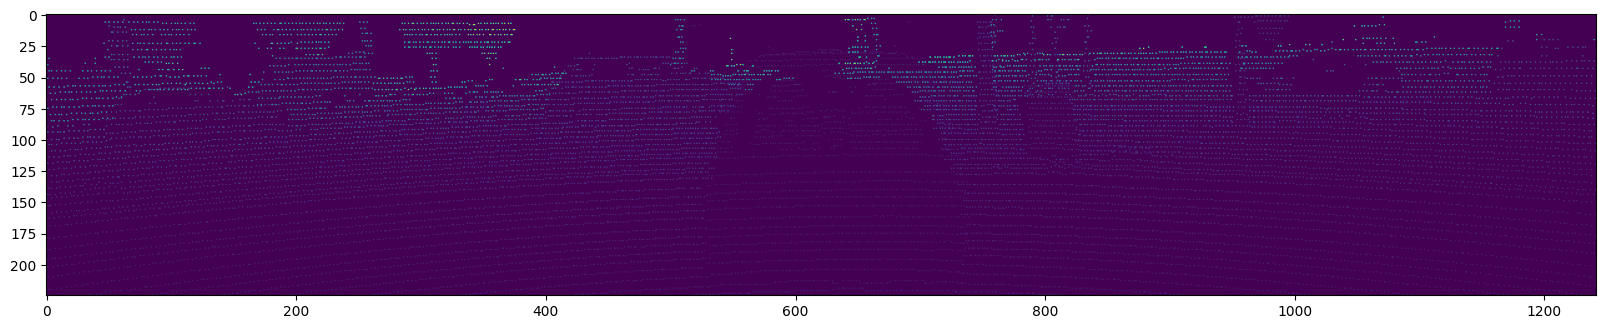

In [20]:
# TODO: Make this dynamic

plt.imshow(lidar_depth_map[150:, :])


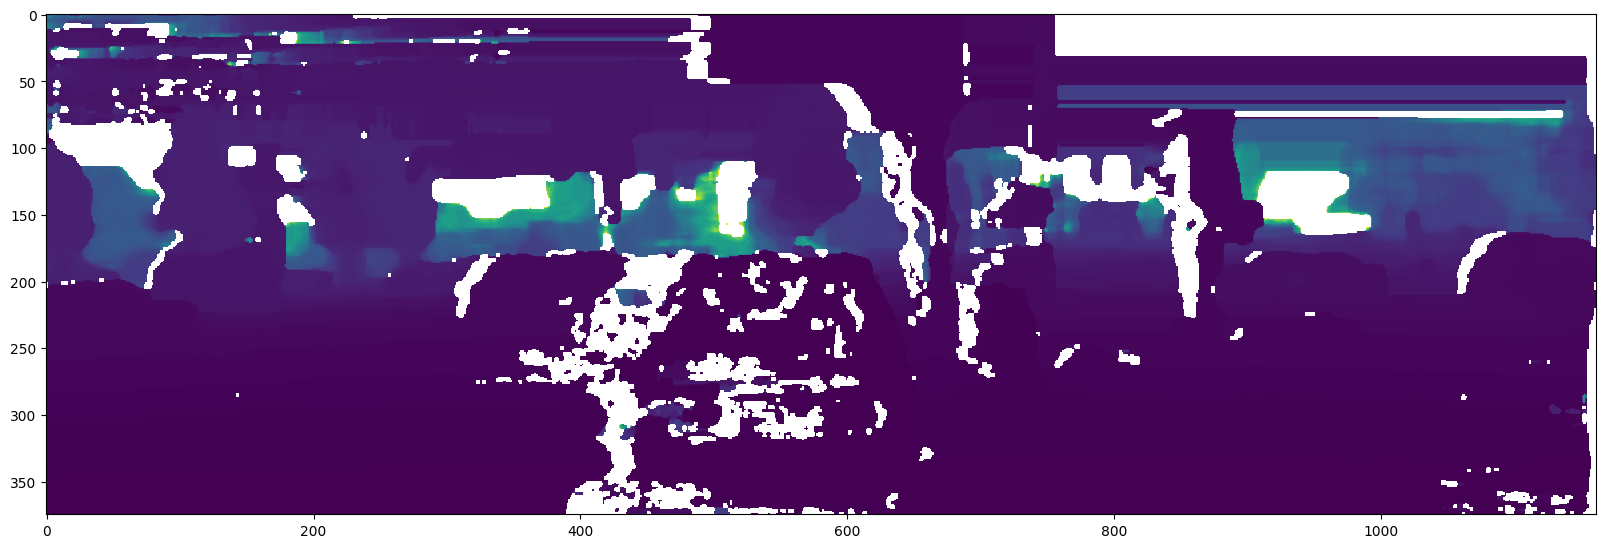

In [21]:
plt.imshow(stereo_depth_map[:, 80:])


## Point Cloud

In [22]:
def depth_map_to_point_cloud(depth_map, flip=True):
    # Truncation
    depth_map_copy = depth_map.copy()
    depth_map_copy[depth_map_copy > 70] = np.nan
    
    # Convert the depth map to Open3D depth image
    depth_image_o3d = o3d.geometry.Image(depth_map_copy.astype(np.float32))

    # Create an Intrinsics object using camera parameters
    height, width = depth_map_copy.shape
    fx, fy = K_left[0, 0], K_left[1, 1]
    cx, cy = K_left[0, 2], K_left[1, 2]
    intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width, height, fx, fy, cx, cy)

    # Create a point cloud from the depth image
    point_cloud = o3d.geometry.PointCloud.create_from_depth_image(
        depth_image_o3d,
        intrinsic,
        # depth_scale=1,
        # depth_trunc=70
    )

    if flip:
        point_cloud.transform([
            [1, 0, 0, 0],
            [0, -1, 0, 0],
            [0, 0, -1, 0],
            [0, 0, 0, 1]
        ])

    return point_cloud


def rgbd_to_point_cloud(color, depth_map, flip=True):
    # Convert the depth map to Open3D depth image
    depth_image_o3d = o3d.geometry.Image(depth_map.astype(np.float32))

    # Convert the depth map to Open3D depth image
    color_image_o3d = o3d.geometry.Image(color)

    # Create RGBD image
    rgbd_image_o3d = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_image_o3d,
        depth_image_o3d,
        depth_scale=1,
        depth_trunc=70
    )

    # Create an Intrinsics object using camera parameters
    height, width = depth_map.shape
    fx, fy = K_left[0, 0], K_left[1, 1]
    cx, cy = K_left[0, 2], K_left[1, 2]
    intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width, height, fx, fy, cx, cy)

    # Create a point cloud from the depth image
    point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image_o3d, intrinsic)

    if flip:
        point_cloud.transform([
            [1, 0, 0, 0],
            [0, -1, 0, 0],
            [0, 0, -1, 0],
            [0, 0, 0, 1]
        ])

    return point_cloud

# Visualize the point cloud
o3d.visualization.draw_geometries([
    # depth_map_to_point_cloud(lidar_depth_map),
    # rgbd_to_point_cloud(left_image, stereo_depth_map),
    rgbd_to_point_cloud(left_image, stereo_depth_map),
    depth_map_to_point_cloud(lidar_depth_map),
])


### Point to Plane Projection

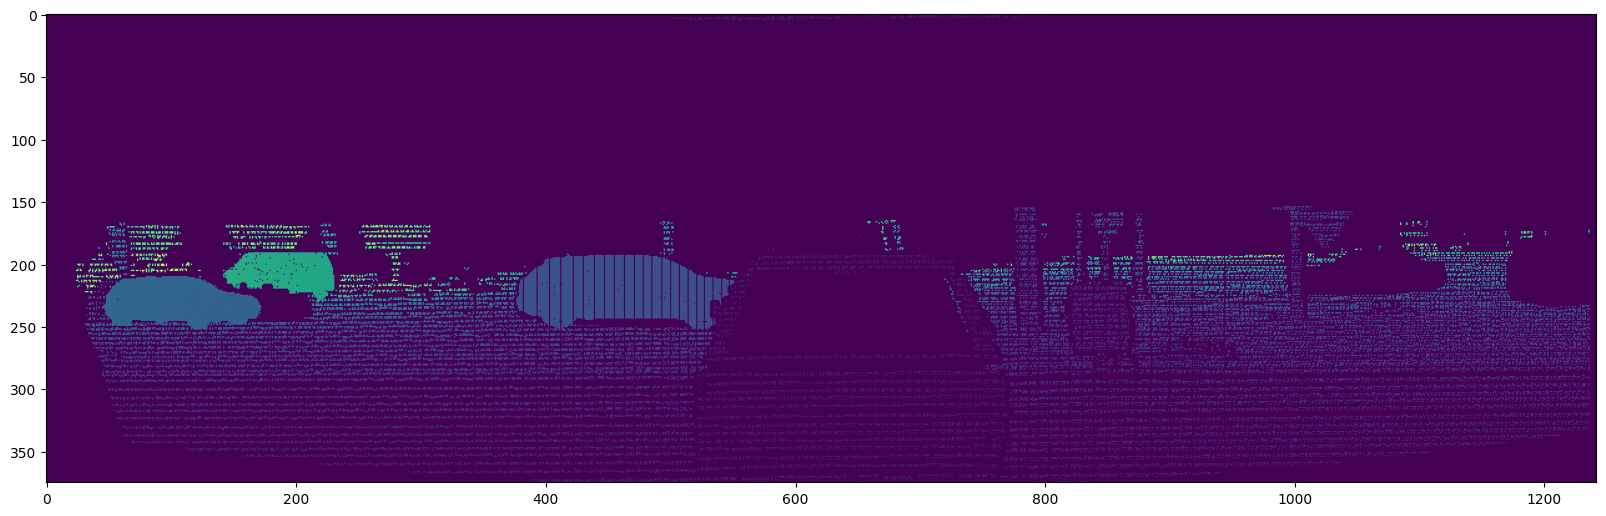

In [136]:
stereo_pcd = depth_map_to_point_cloud(stereo_depth_map)
stereo_points = np.asarray(stereo_pcd.points).copy()

lidar_pcd = depth_map_to_point_cloud(gt_depth_map)
lidar_points = np.asarray(lidar_pcd.points).copy()

ZED_V = left_image.shape[0]
ZED_H = left_image.shape[1]
ZED_V_ANGLE = 83
LiDAR_ANGLE = 30

def cart_to_sph_pts(pts):
    # Convert to CuPy array
    pts = cp.asarray(pts)

    # Convert to spherical coordinates
    x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
    r = cp.sqrt(x**2 + y**2 + z**2)
    theta = cp.arctan(z / cp.sqrt(x**2 + y**2))
    phi = cp.arctan(y / x)

    return cp.column_stack((r, cp.degrees(theta), cp.degrees(phi)))


def remap(old_value, old_min, old_max, new_min, new_max):
    # Function to map a value from one range to another
    old_range = old_max - old_min
    new_range = new_max - new_min
    new_value = (((old_value - old_min) * new_range) / old_range) + new_min
    return new_value


def sph_to_cart_pts(pts):
    pts[:,1] = cp.radians(pts[:,1])
    pts[:,2] = cp.radians(pts[:,2])

    # Convert spherical coordinates to Cartesian coordinates
    x = pts[:, 0] * cp.cos(pts[:, 1]) * cp.cos(pts[:, 2])
    y = pts[:, 0] * cp.cos(pts[:, 1]) * cp.sin(pts[:, 2])
    z = pts[:, 0] * cp.sin(pts[:, 1])
    
    return cp.asarray([x, y, z]).T


def resalet_bi_fonksiyon(pts):
    r, theta, phi = pts.T
    theta = remap(theta, -LiDAR_ANGLE/2, LiDAR_ANGLE/2, ZED_V, 0).astype(cp.int32)
    phi = remap(phi, ZED_V_ANGLE/2, -ZED_V_ANGLE/2, 0, ZED_H).astype(cp.int32)

    proj = cp.zeros((ZED_V, ZED_H), dtype=cp.float32)

    cpx.scatter_max(proj, (theta, phi), r)
    
    return proj

    
def noyisknof_ib_telaser(proj):
    # Make sure input depth array is a CuPy array
    proj = cp.array(proj)
    
    # get the shape of the input array
    m, n = proj.shape
    azimuth_const = ZED_V_ANGLE/n
    polar_const = LiDAR_ANGLE/m

    # Create a grid of row and col indices
    row_indices, col_indices = cp.meshgrid(cp.arange(m), cp.arange(n), indexing='ij')

    # Calculate polar and azimuth angles
    polar_angles = row_indices * polar_const
    azimuth_angles = col_indices * azimuth_const

    # Stack the depth, polar_angles, and azimuth_angles along the last dimension
    pts = cp.stack((proj, polar_angles, azimuth_angles), axis=-1)

    # Reshape the pts array to the desired output shape (m * n, 3)
    pts = pts.reshape(m * n, 3)

    return pts

    
stereo_proj = resalet_bi_fonksiyon(cart_to_sph_pts(np.vstack([stereo_points[:,2], stereo_points[:,0], stereo_points[:,1]]).T))
lidar_proj = resalet_bi_fonksiyon(cart_to_sph_pts(np.vstack([lidar_points[:,2], lidar_points[:,0], lidar_points[:,1]]).T))
    
stereo_points_gubidik = sph_to_cart_pts(noyisknof_ib_telaser(stereo_proj))
stereo_points = np.vstack([stereo_points_gubidik[:,1], stereo_points_gubidik[:,2], stereo_points_gubidik[:,0]]).T

stereo_pcd = o3d.geometry.PointCloud()
stereo_pcd.points = o3d.utility.Vector3dVector(stereo_points.get())
    
# print(stereo_proj.shape)
# cart_to_sph_pts(stereo_points)

plt.imshow(lidar_proj.get())

o3d.visualization.draw_geometries([
    stereo_pcd
])

# Technical Approach

In [25]:
import cupy as cp

# vlp_depth = cp.array(lidar_depth_map)
# zed_depth = cp.array(stereo_depth_map)
# rgb = cp.array(left_image)
gt_depth = cp.array(gt_depth_map[150:, 80:])
vlp_depth = cp.array(lidar_depth_map[150:, 80:])
zed_depth = cp.array(stereo_depth_map[150:, 80:])
rgb = cp.array(left_image[150:, 80:])

def plotScaled(cpArrs, **kwargs):
    N = len(cpArrs)
    
    for i in range(N):
        plt.subplot(N, 1, i + 1)
        plt.imshow(np.log(cpArrs[i][1].get()), **kwargs)
        plt.title(cpArrs[i][0])
        
    plt.rcParams["figure.figsize"] = (50, 20)
    plt.tight_layout()
    plt.show()

## Frequency Analysis

/tmp/ipykernel_19946/2916775519.py:16: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(cpArrs[i][1].get()), **kwargs)
/tmp/ipykernel_19946/2916775519.py:16: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(cpArrs[i][1].get()), **kwargs)


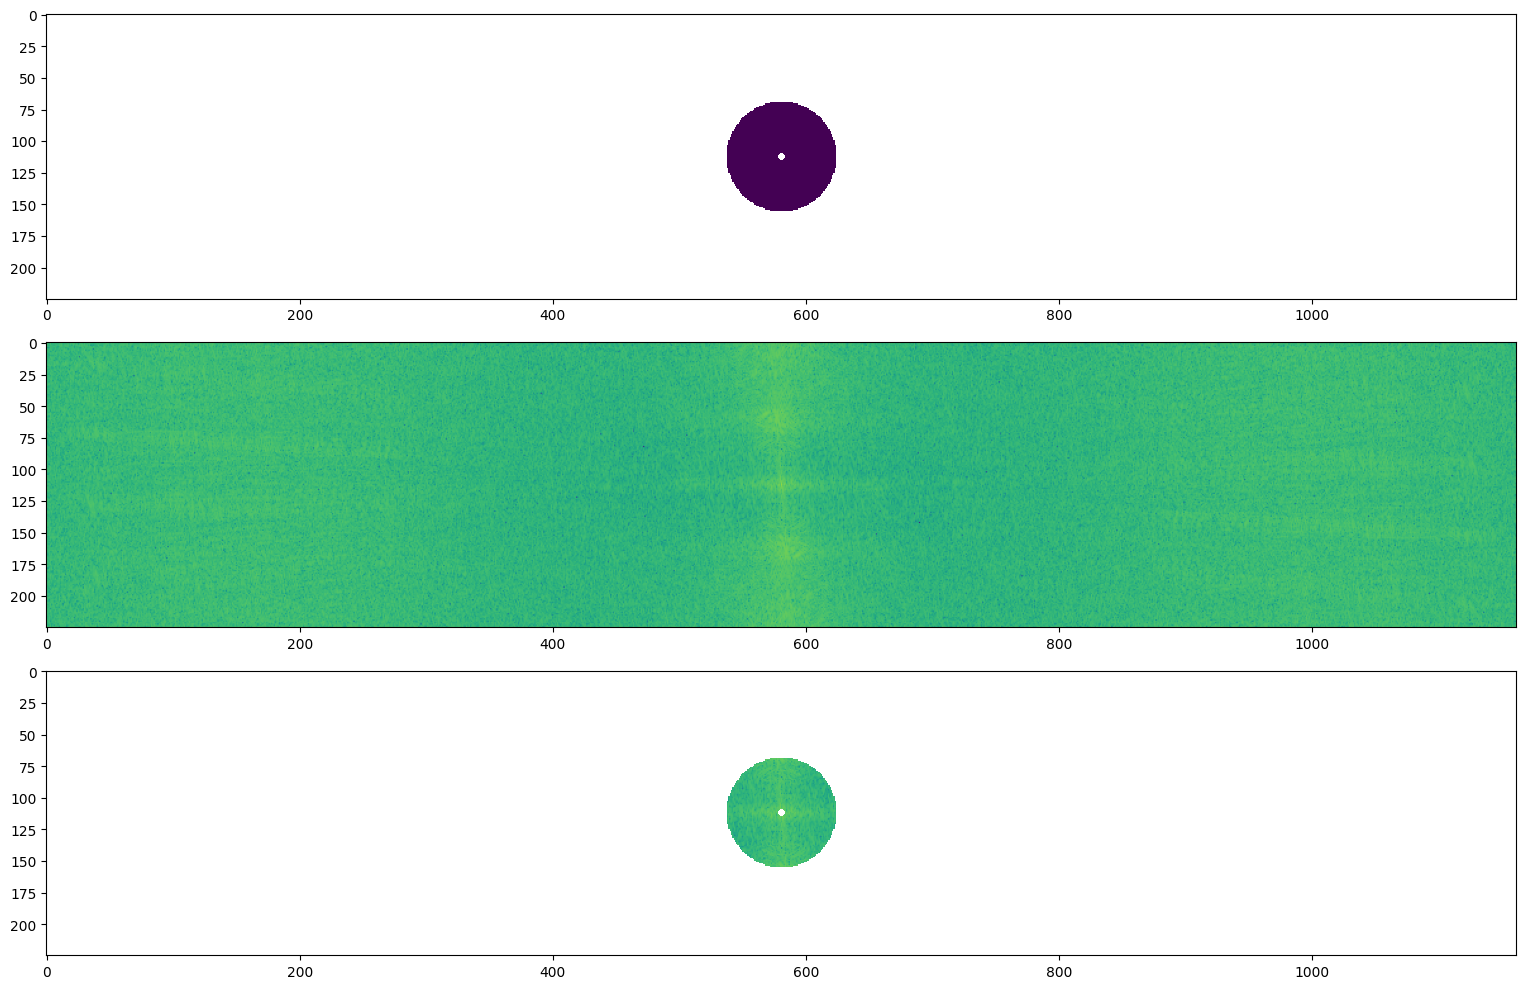

12.5230055


In [26]:
f_img = vlp_depth.copy()
f_img[cp.isnan(f_img)] = cp.nanmean(f_img)

f = cp.fft.fftshift(cp.fft.fft2(f_img))

ncutoff_l = 0.02
ncutoff_h = 0.4

# Create a circular mask of the same size as the spectrum
rows, cols = f_img.shape
crow, ccol = rows // 2, cols // 2
h = np.zeros((rows, cols), np.uint8)
cutoff_h = int(min(crow, ccol)*ncutoff_h)
cutoff_l = int(min(crow, ccol)*ncutoff_l)
cv2.circle(img=h, center=(ccol, crow), radius=cutoff_h, color=1, thickness=-1, lineType=8)
cv2.circle(img=h, center=(ccol, crow), radius=cutoff_l, color=0, thickness=-1, lineType=8)

h = cp.array(h)

plotScaled(
    [
        ('', h),
        ('', cp.log(cp.abs(f))),
        ('', cp.log(cp.abs(f * h))),
    ],
    vmin=0,
    vmax=3
)

print(cp.max(cp.log(cp.abs(f))))

plt.rcParams["figure.figsize"] = (12, 9)
# plt.colorbar()
plt.show()

## Stereo Null Fill

/tmp/ipykernel_19946/2635949862.py:18: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(filled_depth.get()), cmap='rainbow_r')


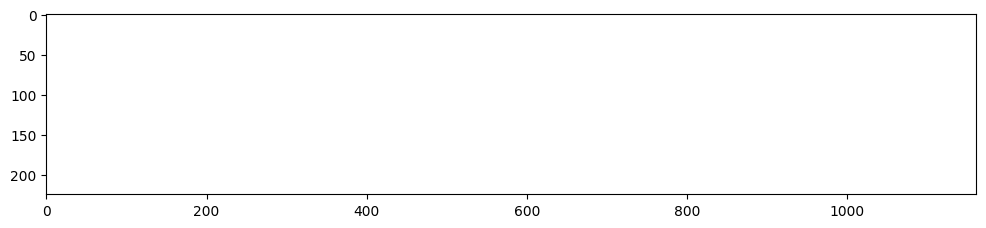

In [27]:
def fillB_withA(A, B):
    # Combine A and B, prioritizing non-NaN values in A
    combined = cp.where(cp.isnan(A), B, A)

    # Calculate the column-wise means of the combined matrix, ignoring NaNs
    col_means = cp.nanmean(combined, axis=0)

    # Replace NaN values in the combined matrix with the column-wise means
    combined = cp.where(cp.isnan(combined), col_means, combined)

    return combined

mask = cp.isnan(zed_depth)

filled_depth = cp.array(cv2.inpaint(zed_depth.get(), mask.get().astype(np.uint8), 3, cv2.INPAINT_TELEA))
filled_depth = fillB_withA(vlp_depth, zed_depth)

plt.imshow(np.log(filled_depth.get()), cmap='rainbow_r')


## PG Implementation

/tmp/ipykernel_19946/3321058434.py:116: RuntimeWarning: divide by zero encountered in log
  vmin = np.min([np.ma.masked_invalid(np.log(vlp_depth.get())).min(),
/tmp/ipykernel_19946/3321058434.py:117: RuntimeWarning: divide by zero encountered in log
  np.ma.masked_invalid(np.log(filled_depth.get())).min()])
/tmp/ipykernel_19946/3321058434.py:118: RuntimeWarning: divide by zero encountered in log
  vmax = np.max([np.ma.masked_invalid(np.log(vlp_depth.get())).max(),
/tmp/ipykernel_19946/3321058434.py:119: RuntimeWarning: divide by zero encountered in log
  np.ma.masked_invalid(np.log(filled_depth.get())).max()])
/tmp/ipykernel_19946/2916775519.py:16: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(cpArrs[i][1].get()), **kwargs)


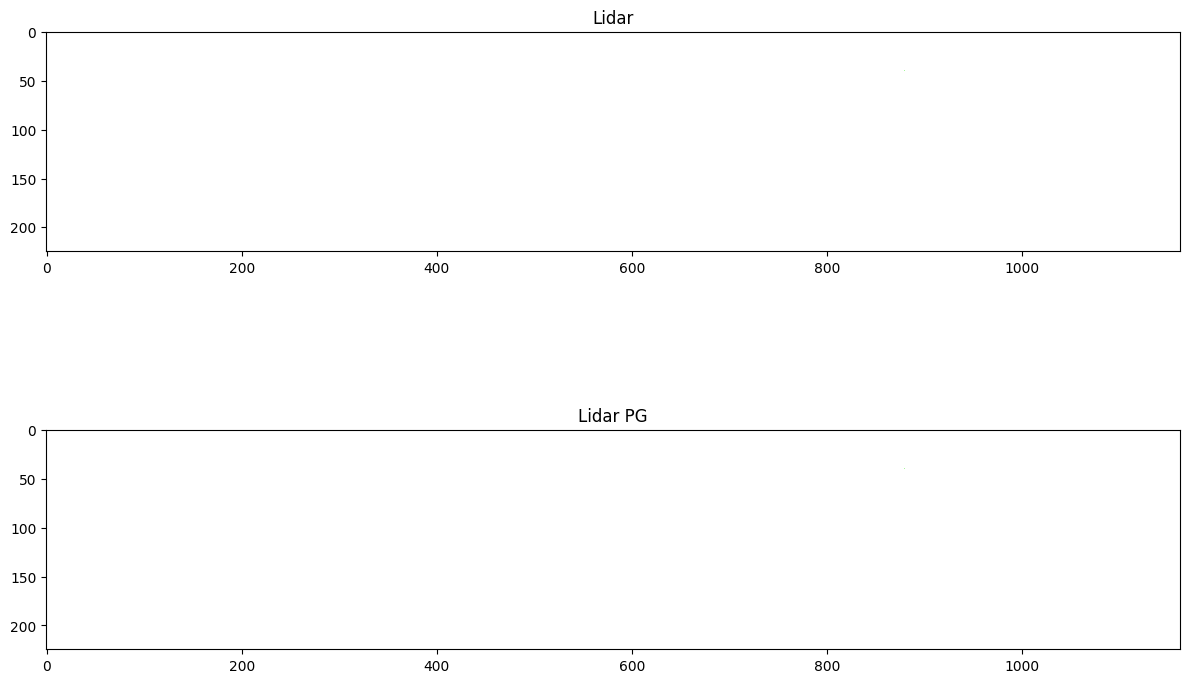

In [28]:
def lpf(img, ncutoff):
    # Apply 2D FFT to the image
    f = cp.fft.fft2(img)

    # Shift the zero frequency component to the center of the spectrum
    fshift = cp.fft.fftshift(f)

    # Create a circular mask of the same size as the spectrum
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    h = np.zeros((rows, cols), np.uint8)
    cutoff = int(min(crow, ccol)*ncutoff)
    cv2.circle(h, (ccol, crow), cutoff, 1, -1)
    # cv2.ellipse(mask, (ccol, crow), (1, 2) * cutoff, 0, 0, 360,  1, -1)

    h = cp.asarray(h)

    # Apply the mask to the shifted spectrum
    fshift_filtered = fshift * h

    # Shift the zero frequency component back to the corner of the spectrum
    f_filtered = cp.fft.ifftshift(fshift_filtered)

    # Apply the inverse 2D FFT to the filtered spectrum
    img_filtered = cp.fft.ifft2(f_filtered)
    img_filtered = cp.real(img_filtered)

    return img_filtered


def bpf(img, ncutoff_l, ncutoff_h):
    # Apply 2D FFT to the image
    f = cp.fft.fft2(img)

    # Shift the zero frequency component to the center of the spectrum
    fshift = cp.fft.fftshift(f)

    # Create a circular mask of the same size as the spectrum
    rows, cols = f_img.shape
    crow, ccol = rows // 2, cols // 2
    h = np.zeros((rows, cols), np.uint8)
    cutoff_h = int(min(crow, ccol)*ncutoff_h)
    cutoff_l = int(min(crow, ccol)*ncutoff_l)
    cv2.circle(img=h, center=(ccol, crow), radius=cutoff_h, color=1, thickness=-1, lineType=8)
    cv2.circle(img=h, center=(ccol, crow), radius=cutoff_l, color=0, thickness=-1, lineType=8)

    h = cp.asarray(h)

    # Apply the mask to the shifted spectrum
    fshift_filtered = fshift * h

    # Shift the zero frequency component back to the corner of the spectrum
    f_filtered = cp.fft.ifftshift(fshift_filtered)

    # Apply the inverse 2D FFT to the filtered spectrum
    img_filtered = cp.fft.ifft2(f_filtered)
    img_filtered = cp.real(img_filtered)

    return img_filtered


def brf(img, ncutoff_l, ncutoff_h):
    # Apply 2D FFT to the image
    f = cp.fft.fft2(img)

    # Shift the zero frequency component to the center of the spectrum
    fshift = cp.fft.fftshift(f)

    # Create a circular mask of the same size as the spectrum
    rows, cols = f_img.shape
    crow, ccol = rows // 2, cols // 2
    h = np.zeros((rows, cols), np.uint8)
    cutoff_h = int(min(crow, ccol)*ncutoff_h)
    cutoff_l = int(min(crow, ccol)*ncutoff_l)
    cv2.circle(img=h, center=(ccol, crow), radius=cutoff_h, color=1, thickness=-1, lineType=8)
    cv2.circle(img=h, center=(ccol, crow), radius=cutoff_l, color=0, thickness=-1, lineType=8)

    h = cp.asarray(h)

    # Apply the mask to the shifted spectrum
    fshift_filtered = fshift - fshift * h

    # Shift the zero frequency component back to the corner of the spectrum
    f_filtered = cp.fft.ifftshift(fshift_filtered)

    # Apply the inverse 2D FFT to the filtered spectrum
    img_filtered = cp.fft.ifft2(f_filtered)
    img_filtered = cp.real(img_filtered)

    return img_filtered


def pg(zed_depth, vlp_depth, threshold=100, filter=lpf, **kwargs):
    mask = ~cp.isnan(vlp_depth)
    filtered = zed_depth

    while threshold > 0:
        filtered[mask] = vlp_depth[mask]
        filtered = filter(filtered, **kwargs)
        threshold -= 1

    filtered[mask] = vlp_depth[mask]

    return filtered


pg_depth = pg(filled_depth.copy(), vlp_depth.copy(), threshold=1, filter=brf, ncutoff_l=0.2, ncutoff_h=0.5)
zed_pg_depth = pg(cp.zeros(zed_depth.shape), zed_depth.copy(), threshold=100, filter=brf, ncutoff_l=0.02, ncutoff_h=0.3)
vlp_pg_depth = pg(cp.zeros(vlp_depth.shape), vlp_depth.copy(), threshold=10, filter=brf, ncutoff_l=0.0, ncutoff_h=0.5)
gt_pg_depth = pg(cp.zeros(gt_depth.shape), gt_depth.copy(), threshold=10, filter=brf, ncutoff_l=0.0, ncutoff_h=0.5)

# Null masking
pg_depth[mask] = cp.NAN

# Plotting
vmin = np.min([np.ma.masked_invalid(np.log(vlp_depth.get())).min(),
              np.ma.masked_invalid(np.log(filled_depth.get())).min()])
vmax = np.max([np.ma.masked_invalid(np.log(vlp_depth.get())).max(),
              np.ma.masked_invalid(np.log(filled_depth.get())).max()])

plotScaled([
    # ('Stereo', zed_depth),
    # ('Stereo PG', zed_pg_depth),
    # ('Stereo PG Diff', cp.abs(zed_pg_depth - zed_depth)),
    ('Lidar', vlp_depth),
    ('Lidar PG', vlp_pg_depth),
    # ('GT', gt_depth),
    # ('GT PG', gt_pg_depth),
    # ('PG', pg_depth),
    # ('PG Diff', pg_depth - filled_depth),
], cmap='rainbow_r', vmin=vmin, vmax=vmax)

### VLP PG

/tmp/ipykernel_19946/2916775519.py:16: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(cpArrs[i][1].get()), **kwargs)


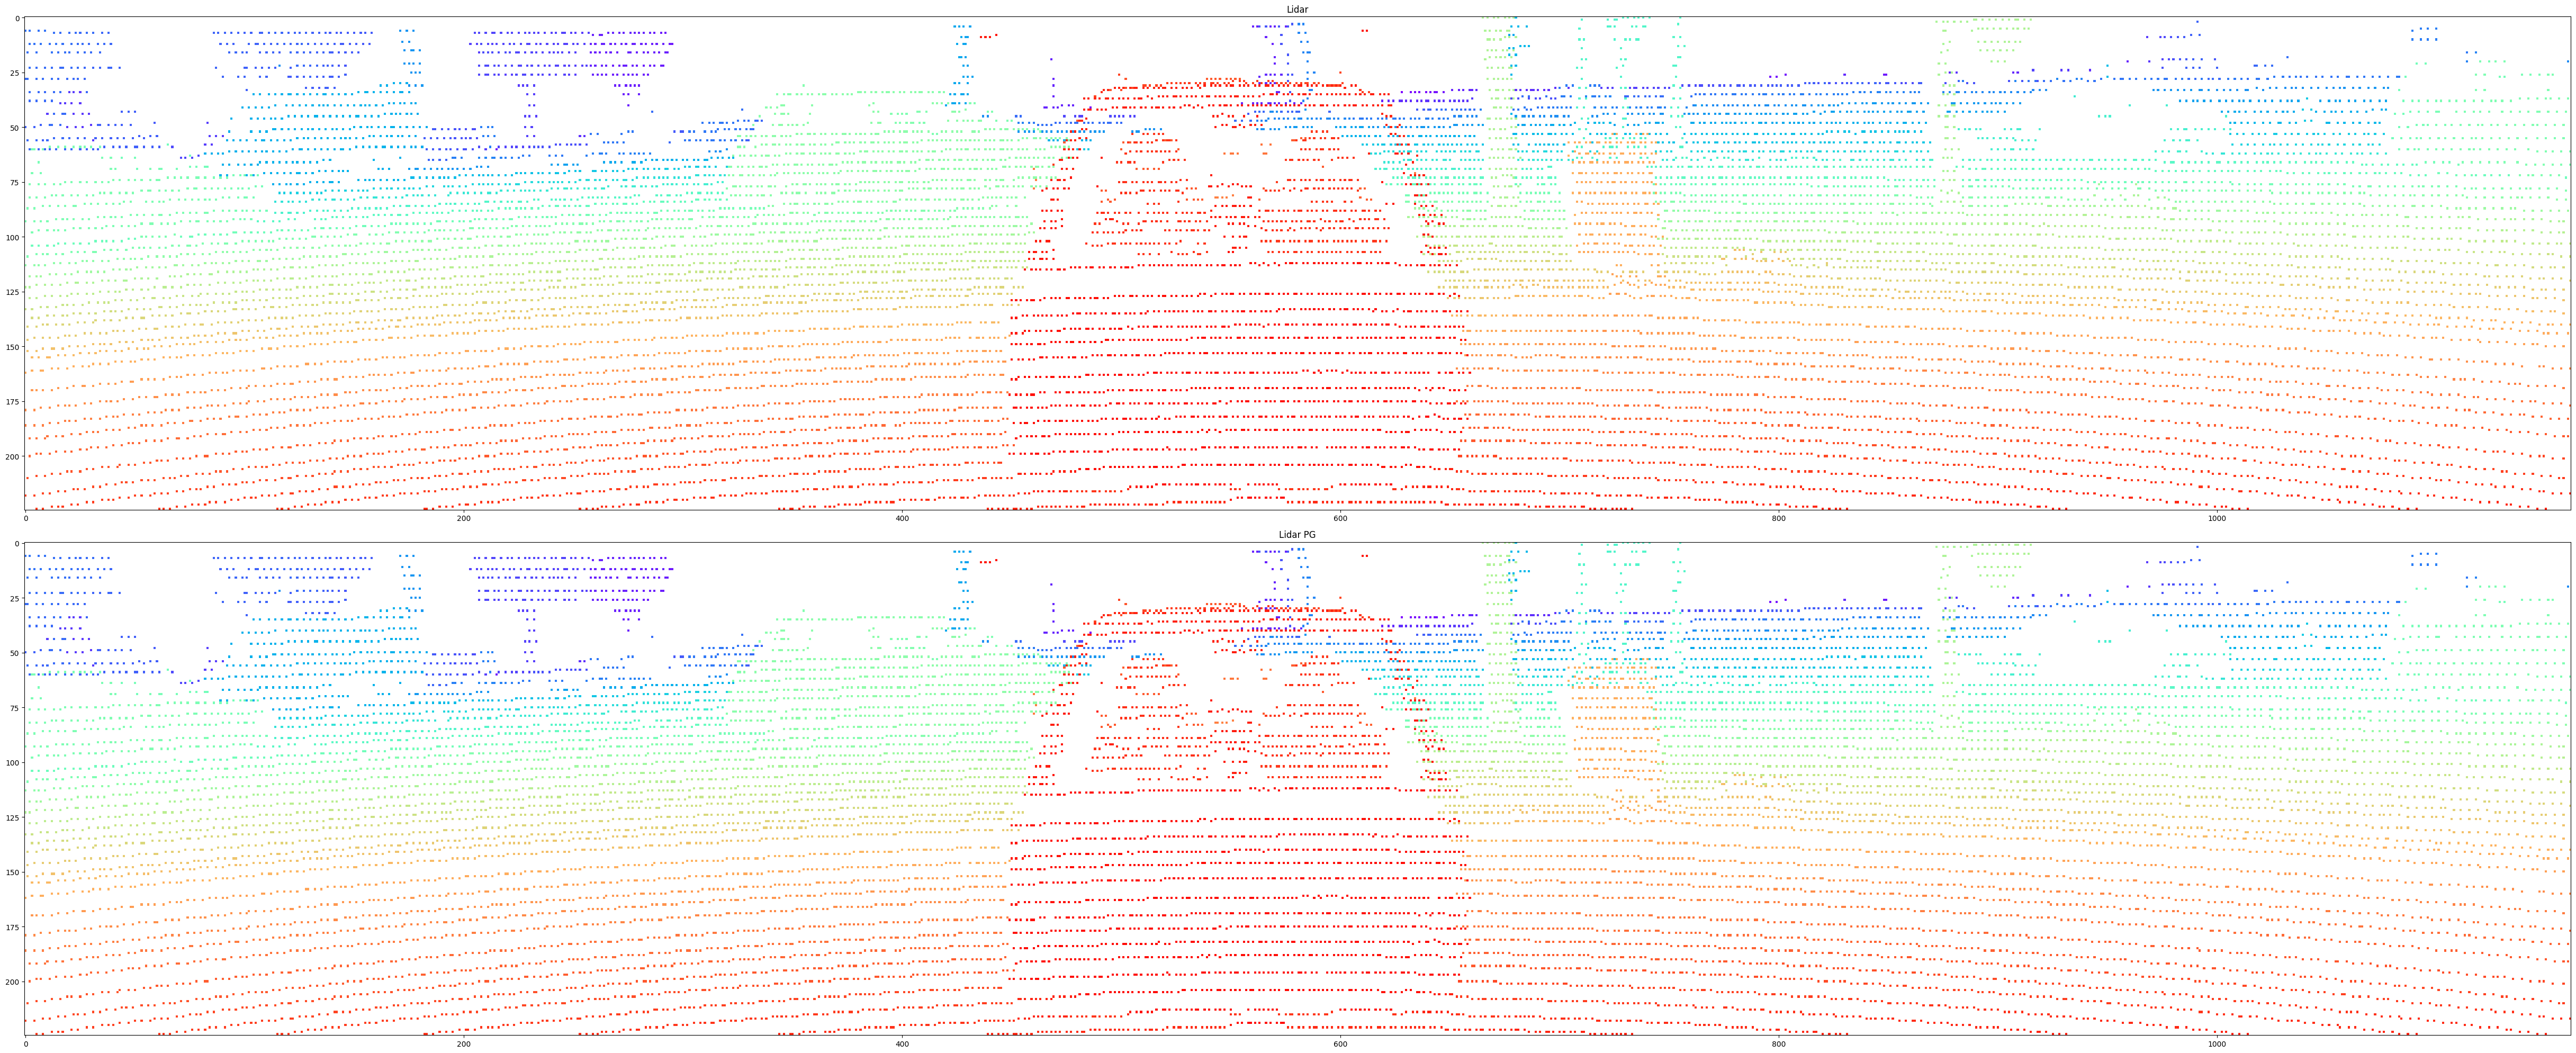

In [29]:
# vlp_pg_depth = pg(cp.zeros(vlp_depth.shape), vlp_depth.copy(), threshold=10, filter=brf, ncutoff_l=0.0, ncutoff_h=1.0)
vlp_pg_depth = pg(cp.zeros(vlp_depth.shape), vlp_depth.copy(), threshold=10, filter=lpf, ncutoff=0.2)

plotScaled([
    ('Lidar', vlp_depth),
    ('Lidar PG', vlp_pg_depth),
], cmap='rainbow_r', vmin=vmin, vmax=vmax)

o3d.visualization.draw_geometries([
    depth_map_to_point_cloud(vlp_pg_depth.get()),
    # rgbd_to_point_cloud(rgb.get(), vlp_depth.get()),
])

In [30]:
from cupyx.scipy.signal import convolve2d

# Filtering
sharpening_kernel = cp.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

Laplacian_kernel = cp.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
])


def filterByKernel(img, kernel):
    f = convolve2d(img, kernel, mode='same')
    g = img + f
    # return g
    return f

import numpy as np
from scipy.spatial import KDTree


def depth_image_to_point_cloud(depth_image):
    """
    Convert a 2D depth image to a 3D point cloud.

    Parameters:
    - depth_image (np.ndarray): A 2D array representing the depth image.

    Returns:
    - np.ndarray: A Nx3 array representing the 3D point cloud.
    """
    # Assume depth image dimensions are (height, width)
    height, width = depth_image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    
    # Flatten x, y, and depth_image to create a list of 3D points
    points = np.stack((x.flatten(), y.flatten(), depth_image.flatten()), axis=-1)
    return points


def denoise_point_cloud(points, k=10, alpha=0.5):
    """
    Denoises a point cloud by adjusting each point based on the average of its k nearest neighbors.

    Parameters:
    - points (np.ndarray): The input point cloud as an Nx3 numpy array.
    - k (int): The number of nearest neighbors to consider for each point.
    - alpha (float): The blending factor determining the weight of the original point position
                     versus the average of its neighbors. 0 means completely using the neighbor
                     average, while 1 means using only the original points.

    Returns:
    - np.ndarray: The denoised point cloud.
    """
    # Build a KD-tree for efficient nearest neighbor searches
    tree = KDTree(points)

    # Find the k nearest neighbors for each point (excluding the point itself)
    distances, indices = tree.query(points, k=k+1)

    # Exclude the first nearest neighbor because it's the point itself
    indices = indices[:, 1:]

    # Calculate the average position of the neighbors for each point
    neighbor_avgs = np.mean(points[indices], axis=1)

    # Blend the original point positions with their neighbor averages
    denoised_points = alpha * points + (1 - alpha) * neighbor_avgs

    return denoised_points


# post = filterByKernel(zed_depth, sharpening_kernel)
# post = denoise_point_cloud(post.get())
# post = denoise_point_cloud(zed_depth.get())

print(type(zed_depth), zed_depth.shape)

# Visualize the point cloud
# o3d.visualization.draw_plotly([
o3d.visualization.draw_geometries([
    # rgbd_to_point_cloud(rgb.get(), zed_depth.get()),
    # rgbd_to_point_cloud(rgb.get(), zed_depth.get()),
    # depth_map_to_point_cloud(filterByKernel(zed_pg_depth, Laplacian_kernel).get()),
    # rgbd_to_point_cloud(rgb.get(), filterByKernel(zed_depth, sharpening_kernel).get()),
    # rgbd_to_point_cloud(rgb.get(), denoise_point_cloud(depth_image_to_point_cloud(zed_depth.get()))),
    # depth_map_to_point_cloud(post),
    # rgbd_to_point_cloud(rgb.get(), tmp_depth.get()),
    # rgbd_to_point_cloud(rgb.get(), zed_depth.get()),
    # rgbd_to_point_cloud(rgb.get(), pg_depth.get()),
    # rgbd_to_point_cloud(rgb.get(), gt_pg_depth.get()),
    depth_map_to_point_cloud(vlp_pg_depth.get()),
    rgbd_to_point_cloud(rgb.get(), vlp_depth.get()),
    # depth_map_to_point_cloud(vlp_depth.get()),
    # depth_map_to_point_cloud(gt_depth.get()),
    # depth_map_to_point_cloud(pg_depth.get()),
])


<class 'cupy._core.core.ndarray'> (225, 1162)


# Benchmark

### Custom MAE

In [31]:
def calculate_custom_mae(predicted, ground_truth, max_error=0.2):
    """
    Calculate a custom Mean Absolute Error (MAE) between predicted and ground truth images.
    NaN values in the ground truth are ignored. NaN values in the predicted image, where
    the ground truth is not NaN, are penalized.

    Parameters:
    predicted (numpy.ndarray): Predicted depth image.
    ground_truth (numpy.ndarray): Ground truth depth image.

    Returns:
    float: The custom MAE value.
    """
    error = (ground_truth - predicted)  / ground_truth
    
    error = np.ma.masked_less(error, -max_error)
    error = np.ma.masked_greater(error, max_error)
    error = np.ma.masked_invalid(error)
    
    mae = np.nanmean(np.abs(error))

    return mae * 100


print(calculate_custom_mae(gt_depth.get(), gt_depth.get()))
print(calculate_custom_mae(pg_depth.get(), gt_depth.get()))
print(calculate_custom_mae(zed_depth.get(), gt_depth.get()))
print(calculate_custom_mae(vlp_depth.get(), gt_depth.get()))


0.0
3.2628271728754044
2.581539563834667
3.3141184598207474


### RMSE

In [32]:
def calculate_rmse(predicted, ground_truth, max_error=0.2):
    """
    Calculate the Root Mean Square Error (RMSE) between predicted and ground truth images,
    taking into account NaN values.

    Parameters:
    predicted (numpy.ndarray): Predicted depth image.
    ground_truth (numpy.ndarray): Ground truth depth image.

    Returns:
    float: The RMSE value.
    """
    error = (ground_truth - predicted)  / ground_truth
    
    error = np.ma.masked_less(error, -max_error)
    error = np.ma.masked_greater(error, max_error)
    error = np.ma.masked_invalid(error)

    rmse = np.sqrt(np.mean(np.square(error)))
    
    return rmse * 100


print(calculate_rmse(gt_depth.get(), gt_depth.get()))
print(calculate_rmse(pg_depth.get(), gt_depth.get()))
print(calculate_rmse(masked_zed_depth.get(), gt_depth.get()))
print(calculate_rmse(vlp_depth.get(), gt_depth.get()))


0.0
4.388972135225328


NameError: name 'masked_zed_depth' is not defined

### edge_preservation_quality (USELESS)

In [ ]:
# import numpy as np
# from skimage.filters import sobel
# from skimage.measure import label
# from scipy.ndimage import binary_dilation
# from skimage.metrics import structural_similarity as ssim

# def preprocess_image(image):
#     """
#     Replace NaN values with 0, assuming NaNs indicate missing data.
#     """
#     return np.nan_to_num(image, nan=0)

# def dilate_edges(edges, iterations=5):
#     """
#     Dilate the edges to account for sparsity in the ground truth.

#     Parameters:
#     edges (numpy.ndarray): Edge map.
#     iterations (int): Number of dilation iterations.

#     Returns:
#     numpy.ndarray: Dilated edge map.
#     """
#     return binary_dilation(edges, iterations=iterations)

# def calculate_custom_edge_metric(predicted_edges, ground_truth_edges):
#     """
#     Calculate a custom edge metric considering the dilated ground truth edges.

#     Parameters:
#     predicted_edges (numpy.ndarray): Edge map from the predicted image.
#     ground_truth_edges (numpy.ndarray): Dilated edge map from the ground truth image.

#     Returns:
#     float: Custom metric based on the comparison.
#     """
#     # Calculate discrepancies
#     missing_edges = np.logical_and(~predicted_edges, ground_truth_edges)
#     false_edges = np.logical_and(predicted_edges, ~ground_truth_edges)

#     # Penalization factors (tunable)
#     missing_edge_penalty = 1.0
#     false_edge_penalty = 1.0

#     # Calculate penalties
#     missing_edge_score = np.sum(missing_edges) * missing_edge_penalty
#     false_edge_score = np.sum(false_edges) * false_edge_penalty

#     # Normalize by the number of ground truth edges
#     total_ground_truth_edges = np.sum(ground_truth_edges)

#     if total_ground_truth_edges > 0:
#         score = (missing_edge_score + false_edge_score) / total_ground_truth_edges
#     else:
#         score = 0  # Handle case with no ground truth edges

#     return score

# def evaluate_edge_preservation(predicted, ground_truth):
#     """
#     Evaluate edge preservation quality with penalization for sparsity.

#     Parameters:
#     predicted (numpy.ndarray): Predicted depth image.
#     ground_truth (numpy.ndarray): Ground truth depth image.

#     Returns:
#     float: Custom edge preservation score.
#     """
#     # Preprocess images
#     predicted_preprocessed = preprocess_image(predicted)
#     ground_truth_preprocessed = preprocess_image(ground_truth)

#     # Detect edges
#     predicted_edges = sobel(predicted_preprocessed) > 0.01  # Edge threshold
#     ground_truth_edges = sobel(ground_truth_preprocessed) > 0.01

#     # Handle sparsity by dilating ground truth edges
#     dilated_ground_truth_edges = dilate_edges(ground_truth_edges)

#     # Calculate custom edge metric
#     score = calculate_custom_edge_metric(predicted_edges, dilated_ground_truth_edges)

#     return score


# print(evaluate_edge_preservation(gt_depth.get(), gt_depth.get()))
# print(evaluate_edge_preservation(pg_depth.get(), gt_depth.get()))
# print(evaluate_edge_preservation(masked_zed_depth.get(), gt_depth.get()))
# print(evaluate_edge_preservation(vlp_depth.get(), gt_depth.get()))


: 

### depth_consistency

In [ ]:
# import numpy as np

# def calculate_depth_consistency(predicted, ground_truth, min_valid_points=10):
#     """
#     Calculate depth consistency in regions with sufficient ground truth data.

#     Parameters:
#     predicted (numpy.ndarray): Dense predicted depth image.
#     ground_truth (numpy.ndarray): Sparse ground truth depth image.
#     min_valid_points (int): Minimum number of valid ground truth points to consider a region.

#     Returns:
#     dict: A dictionary containing variance metrics for both predicted and ground truth, and a consistency score.
#     """
#     if predicted.shape != ground_truth.shape:
#         raise ValueError("Predicted and ground truth images must have the same shape.")

#     # Mask for valid ground truth points
#     valid_gt_mask = ~np.isnan(ground_truth)

#     # Mask for pixels where predicted is NaN but ground truth is not
#     valid_pred_mask = ~np.isnan(predicted)

#     # Identify regions with sufficient ground truth data
#     # Here, we simplify by considering the entire image as a single region if it has enough valid points
#     if np.sum(valid_gt_mask) < min_valid_points:
#         return {"error": "Not enough valid ground truth points for comparison."}

#     # Calculate variance in these regions for both predicted and ground truth
#     gt_variance = np.var(ground_truth[valid_gt_mask])
#     pred_variance = np.var(predicted[valid_pred_mask])

#     # Compare variances to assess consistency. A lower difference indicates better consistency.
#     variance_difference = np.abs(gt_variance - pred_variance)

#     # Return the variances and the difference as a measure of consistency
#     return {
#         "ground_truth_variance": gt_variance,
#         "predicted_variance": pred_variance,
#         "consistency_score": 1 / (1 + variance_difference)  # Higher score indicates better consistency
#     }


# print(calculate_depth_consistency(gt_depth.get(), gt_depth.get()))
# print(calculate_depth_consistency(pg_depth.get(), gt_depth.get()))
# print(calculate_depth_consistency(masked_zed_depth.get(), gt_depth.get()))
# print(calculate_depth_consistency(vlp_depth.get(), gt_depth.get()))


: 

## Benchmark PoC

In [ ]:
A = np.array([
    [2, np.nan, 4, 5, 2, 5, 8, 4],
    [6, np.nan, 7, 8, 4, 2, 8, 4],
    [6, np.nan, 7, 8, 4, 3, 4, 2],
    [3, 4, 5, 5, 2, 5, 8, 4],
    [6, 3, 7, 8, 4, np.nan, np.nan, 5],
    [8, 4, 6, 3, 7, np.nan, np.nan, 1],
    [0, 9, np.nan, np.nan, 3, 4, 5, 2],
    [5, 2, np.nan, 4, 5, 2, 5, 8],
])

B = np.array([
    [2, np.nan, 4, 5, 2, 5, 8, 4],
    [6, np.nan, 7, 8, 4, 2, 8, 4],
    [6, np.nan, 7, 8, 4, 3, 4, 2],
    [3, 4, 5, 5, 2, np.nan, 8, 4],
    [6, 3, 7, 8, 4, np.nan, np.nan, 5],
    [8, 4, 6, np.nan, 7, np.nan, np.nan, 1],
    [0, 9, np.nan, np.nan, 3, 4, 5, 2],
    [5, 2, np.nan, 4, 5, 2, 5, 8],
])


def calculate_custom_mae(predicted, ground_truth):
    mae = np.nanmean(np.abs((ground_truth - predicted) / ground_truth))
    return mae


print(calculate_custom_mae(A, B * 1.1))
print(calculate_custom_mae(A * 1.1, B))

A = np.array([
        [5.5, np.nan],
        [1, np.nan],
        [1, 2],
    ], dtype=np.float64)

B = np.array([
        [5, 1],
        [np.nan, np.nan],
        [np.nan, 2.2],
    ], dtype=np.float64)

print(calculate_custom_mae(A, B))
print(A)
print(A - B)
print((A - B) / A)
print(np.nanmean((A - B) / A))
print(np.nanmean(np.divide((A - B), A)))

: 

In [ ]:
(5 - 5.5) / 5

: 